In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import median_filter
import scipy.interpolate as interp
from scipy.signal import spectrogram
from skimage.transform import resize
from transformers import ViTForImageClassification
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
# from facenet_pytorch import MTCNN
from torchvision import transforms
from collections import defaultdict
from google.colab.patches import cv2_imshow
from PIL import Image
from transformers import ViTImageProcessor
from torchvision.transforms import Compose, Resize, RandomRotation, RandomAdjustSharpness, RandomHorizontalFlip, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image
import cv2


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Testing Teacher ViT model on video

### Initialize Teacher model

In [ ]:
model_name = "dima806/facial_emotions_image_detection"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
teacher_model = AutoModelForImageClassification.from_pretrained(model_name)
teacher_model.eval()

### Face detection using MTCNN

Github: https://github.com/timesler/facenet-pytorch

In [ ]:
# Initialize MTCNN
mtcnn = MTCNN(image_size=224, margin=0)

# Load image
img = Image.open('/content/drive/MyDrive/ac.jpg')  # Any image with Human expression

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img)

# Denormalize: Convert range [-1, 1] back to [0, 1]
img_cropped = (img_cropped + 1) / 2

# Convert to PIL Image
to_pil = transforms.ToPILImage()
img_pil = to_pil(img_cropped)

# Show or save the image
img_pil.show()
# img_pil.save("output.jpg")


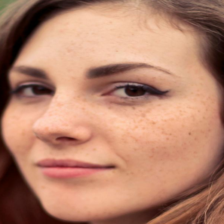

In [ ]:
img_pil

### Video testing

In [ ]:
# Class names for emotions
class_names = ["sad", "disgust", "angry", "neutral", "fear", "surprise", "happy"]

emotion_counts = defaultdict(int)

def predict_emotion(image):
    # Preprocess the image
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze()

    # Get the highest predicted emotion
    predicted_class = torch.argmax(probs).item()
    return class_names[predicted_class]


def process_video(video_path, frame_interval=1.5):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = 0
    start_time = time.time()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process frames at the specified interval
        if frame_count % (fps * frame_interval) == 0:
            # Convert OpenCV BGR image to RGB (MTCNN expects RGB)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Detect and crop the face
            img_cropped = mtcnn(frame_rgb)

            if img_cropped is not None:  # If a face is detected
                # Convert the cropped tensor to a PIL Image
                img_cropped_pil = (img_cropped + 1) / 2
                to_pil = transforms.ToPILImage()
                img_cropped_pil = to_pil(img_cropped_pil)
                img_np = np.array(img_cropped_pil)

                # Predict the emotion
                emotion = predict_emotion(img_cropped_pil)
                emotion_counts[emotion] += 1  # Count the emotion

                print(f"Predicted Emotion: {emotion}")
                # Display the cropped face and emotion
                plt.imshow(img_np)
                plt.axis("off")  # Hide axes
                plt.show()

        frame_count += 1

    cap.release()
    total_time = time.time() - start_time

    # Print total emotion counts and total processing time
    print(f"\nTotal Processing Time: {total_time:.2f} seconds")
    print("Total Emotion Counts:")
    for emotion, count in emotion_counts.items():
        print(f"{emotion}: {count}")

# Video path
video_path = "/content/drive/MyDrive/Quan Emotions/Neutral/teacher_data_neutral/neutral18.mp4"  # Replace with your video path
process_video(video_path)


# Spectrograms Explore

### Amplitude and Spectrogram processing

In [ ]:
# Hampel Filter
def hampel_filter_optimized(signal, window_size=100, n_sigma=3):
    signal = np.array(signal)
    k = 1.4826  # Scale factor for Gaussian distribution
    medians = median_filter(signal, size=window_size, mode='mirror')
    mads = k * median_filter(np.abs(signal - medians), size=window_size, mode='mirror')
    outliers = np.abs(signal - medians) > n_sigma * mads
    signal[outliers] = medians[outliers]
    return signal

# Butterworth Filter
def butterworth_filter(signal, cutoff=0.1, fs=1.0, order=6, filter_type='low'):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# PCA (Optional)
def apply_pca(data, n_components=10):
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data_standardized)

    return pca_data

# Preprocessing Pipeline
def preprocess_csi_data_optimized(A, n_components=10, window_size=100, n_sigma=3, cutoff=0.1):
    batch_size, length, dim = A.shape
    processed_data = []

    # Apply Hampel filter
    A = np.apply_along_axis(hampel_filter_optimized, 1, A, window_size=window_size, n_sigma=n_sigma)

    # Apply Butterworth filter
    A = np.apply_along_axis(butterworth_filter, 1, A, cutoff=cutoff)

    # Apply PCA
    # for batch_idx in range(batch_size):
    #     pca_result = apply_pca(A[batch_idx], n_components=n_components)
    #     processed_data.append(pca_result)

    # return np.array(processed_data)
    return A

# Parameters
segment_length = 6000
step_size = 6000

def segment_csi_data(csi_data):
    segments = []
    for i in range(0, len(csi_data) - segment_length + 1, step_size):
        segments.append(csi_data[i:i + segment_length])
    return segments


In [ ]:
# csi_file = "/content/drive/MyDrive/Quan Emotions/Neutral/student_data_neutral/neutral27.csv"
csi_file = "/content/drive/MyDrive/Quan Emotions/Happy/student_data_happy/happy41.csv"
# csi_file = "/content/drive/MyDrive/Quan Emotions/Angry/student_data_angry/angry15.csv"
# csi_file = "/content/drive/MyDrive/Quan Emotions/Sad/student_data_sad/sad27.csv"


csi_data = pd.read_csv(csi_file, usecols=[25], header=None, skiprows=1)
csi_data = csi_data.dropna(subset=[25])
csi_data = csi_data[25].apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' '))
csi_data = np.stack(csi_data.values)

# Segment the CSI data
csi_segments = segment_csi_data(csi_data)
csi_data_list = np.stack(csi_segments, axis=0)

#=============================== Raw CSI data =================================================
# Compute amplitude of CSI data for Spectrogram
A = np.sqrt(csi_data_list[:, :, ::2]**2 + csi_data_list[:, :, 1::2]**2)
A = np.transpose(A, (0, 2, 1))
print("Raw data :", A.shape)  # (4, 64, 6000)

#============================== CSI data with fitlers ==========================================
AB = np.sqrt(csi_data_list[:, :, ::2]**2 + csi_data_list[:, :, 1::2]**2)
n_components = 10  # Number of PCA components

processed_data = preprocess_csi_data_optimized(AB, n_components=n_components)
processed_data_spectro = np.transpose(processed_data, (0, 2, 1))

print("Processed Shape:", processed_data.shape)  # (Batch, time_step, features) (4, 6000, 64)
print("Processed Shape:", processed_data_spectro.shape)  # (Batch, features, time_step) (4, 64, 6000)

(4, 64, 6000)
Processed Shape: (4, 6000, 64)
Processed Shape: (4, 64, 6000)


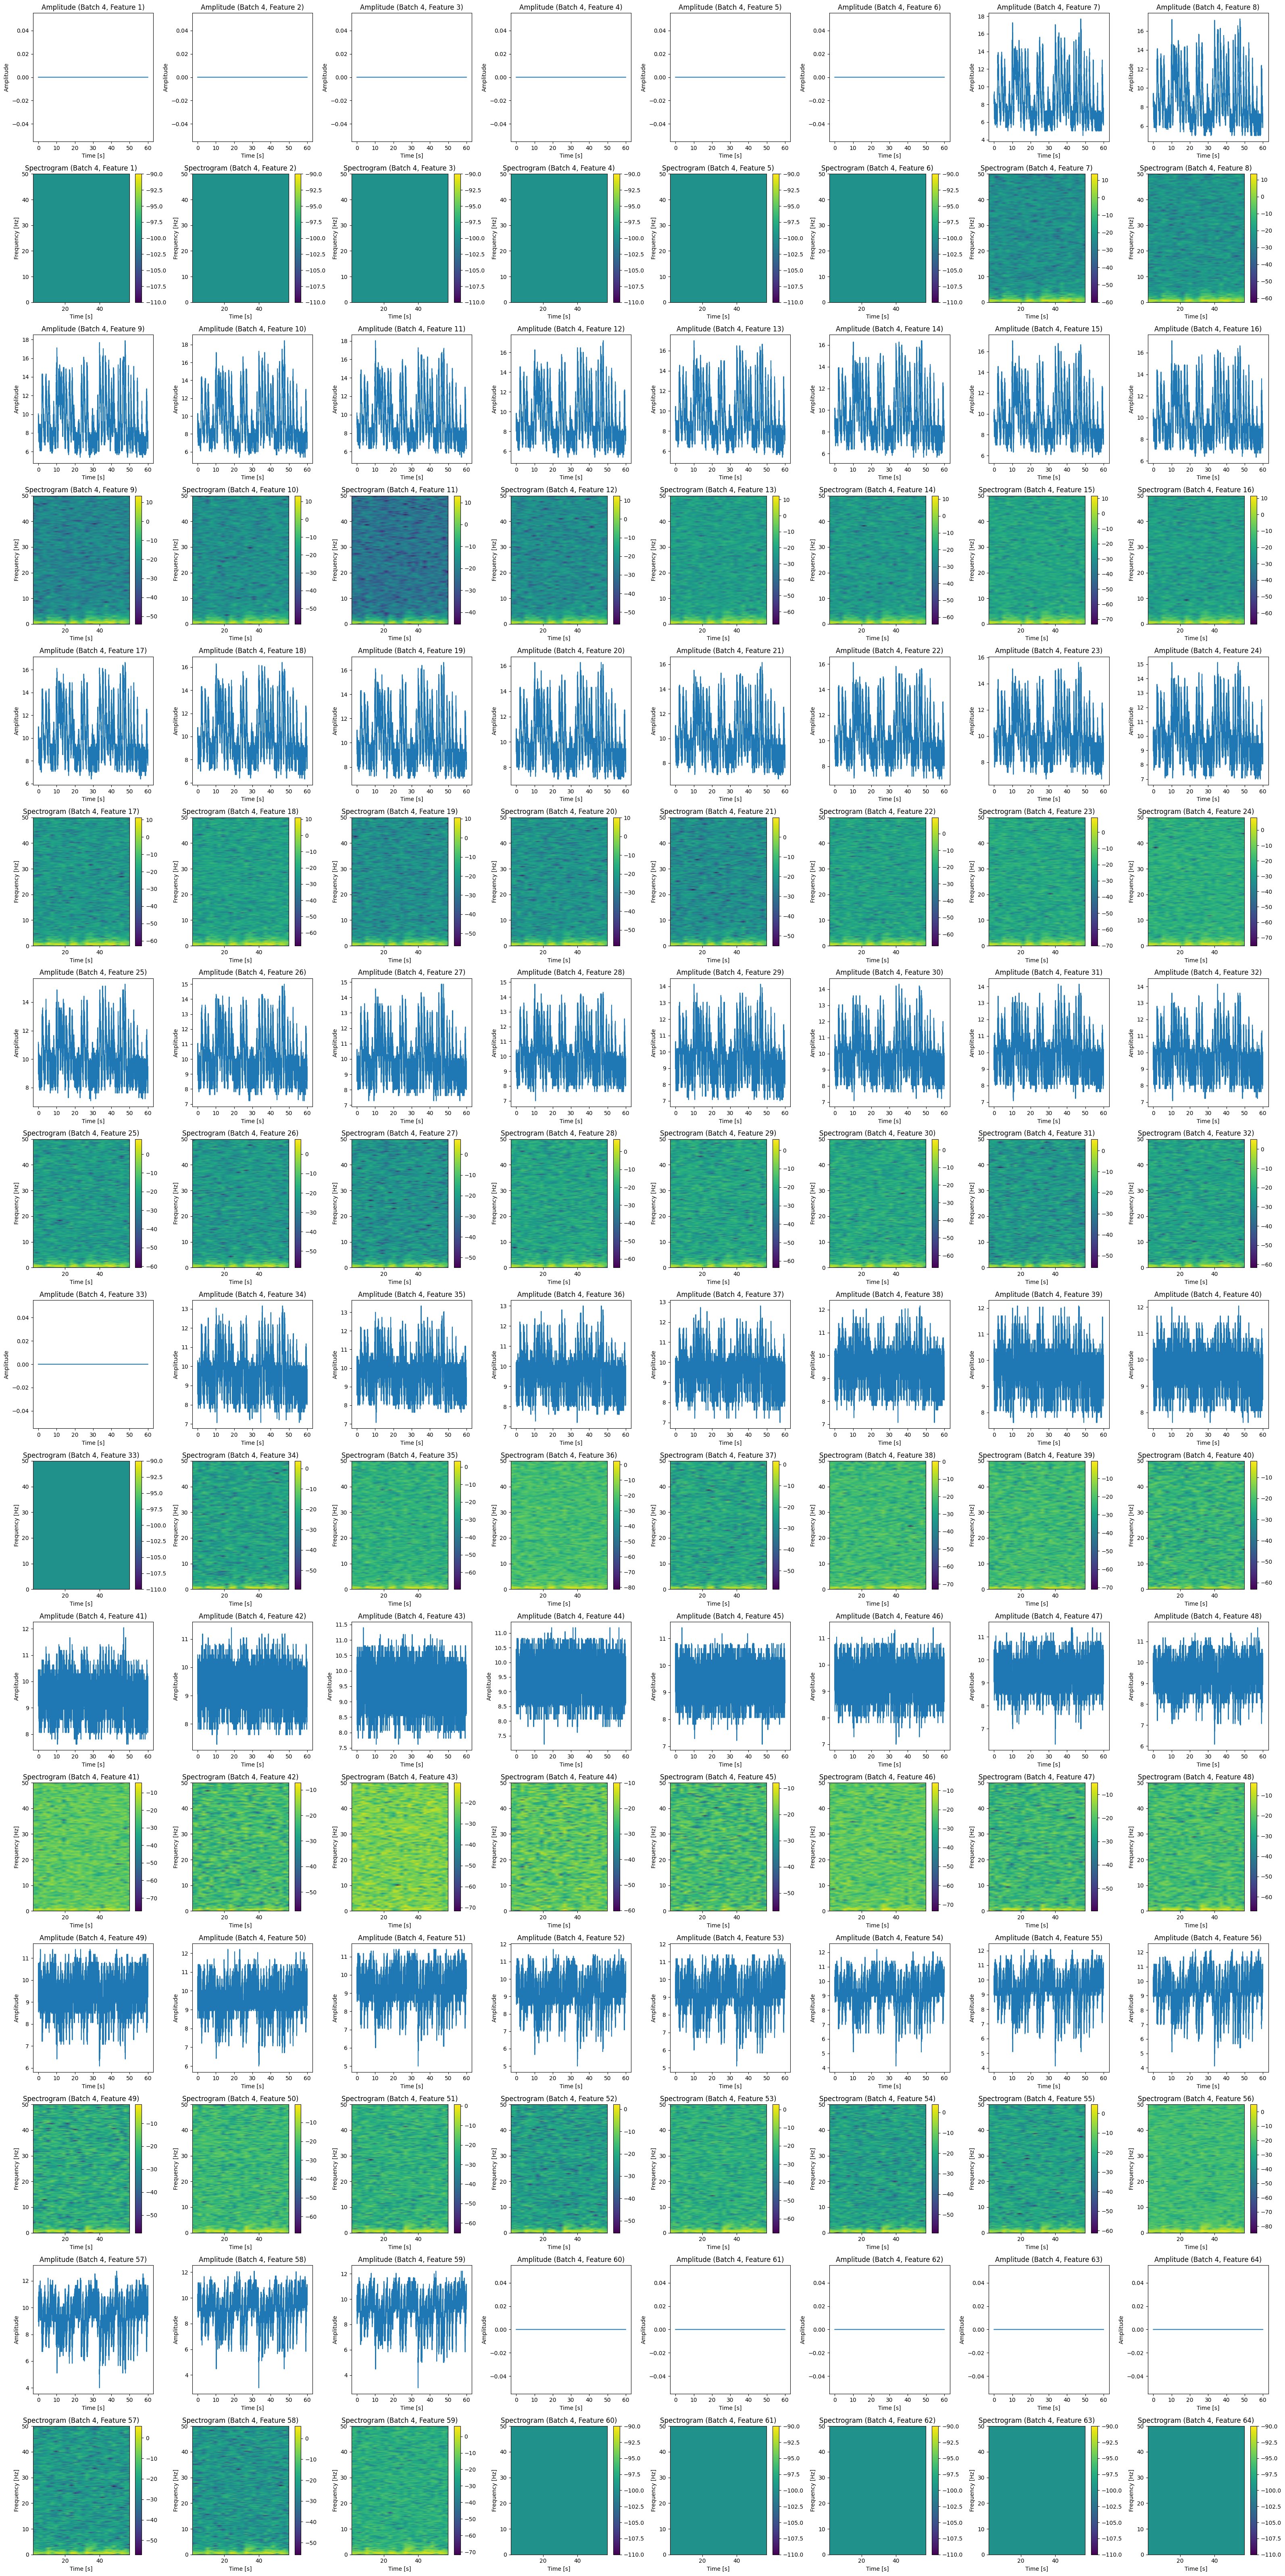

In [ ]:
num_batch, num_feature, time_step = A.shape
fs = 100

grid_size = int(np.ceil(np.sqrt(num_feature))) 

batch = 3
fig, axs = plt.subplots(grid_size * 2, grid_size, figsize=(4 * grid_size, 4 * grid_size * 2))
axs = np.array(axs).reshape(grid_size * 2, grid_size)

for feature in range(num_feature):
    signal = A[batch, feature, :]       # Changing raw data or filter CSI data right here
    f, t, Sxx = spectrogram(signal, fs)
    Sxx = np.where(Sxx > 0, Sxx, 1e-10)

    row = (feature // grid_size) * 2 
    col = feature % grid_size

    # Plot amplitude over time
    axs[row, col].plot(np.linspace(0, time_step / fs, time_step), signal)
    axs[row, col].set_title(f"Amplitude (Batch {batch+1}, Feature {feature+1})")
    axs[row, col].set_ylabel("Amplitude")
    axs[row, col].set_xlabel("Time [s]")

    # Plot spectrogram
    pcm = axs[row + 1, col].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    axs[row + 1, col].set_title(f"Spectrogram (Batch {batch+1}, Feature {feature+1})")
    axs[row + 1, col].set_ylabel("Frequency [Hz]")
    axs[row + 1, col].set_xlabel("Time [s]")
    axs[row + 1, col].set_ylim(0, fs/2)
    fig.colorbar(pcm, ax=axs[row + 1, col])

plt.tight_layout()
plt.show()


### Save the best subcarriers

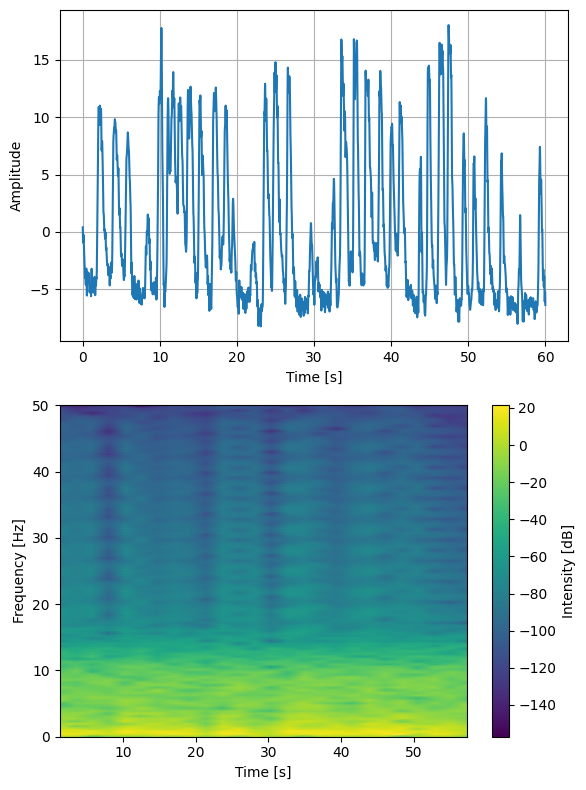

Saved single image: Batch_4_Feature_1_Amplitude_Spectrogram.png


In [ ]:
num_batch, num_feature, time_step = processed_data_spectro.shape
fs = 100 

# The specific batch and feature you want to save
# Batch 1 is index 0, Feature 13 is index 12.
target_batch_idx = 3     # Example: to get "Batch 1" -> 0
target_feature_idx = 0  # Example: to get "Feature 13" -> 12

signal = processed_data_spectro[target_batch_idx, target_feature_idx, :]

# Calculate Spectrogram
f, t_spec, Sxx = spectrogram(signal, fs=fs)
Sxx = np.where(Sxx > 0, Sxx, 1e-10)

fig, axs = plt.subplots(2, 1, figsize=(6, 8))


# Plot
# Amplitude
time_vector = np.linspace(0, time_step / fs, time_step)
axs[0].plot(time_vector, signal)
# axs[0].set_title(f"Amplitude (Batch {target_batch_idx+1}, Feature {target_feature_idx+1})") # Title 
axs[0].set_ylabel("Amplitude")
axs[0].set_xlabel("Time [s]")
axs[0].grid(True)

# Spectrogram
pcm = axs[1].pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
# axs[1].set_title(f"Spectrogram (Batch {target_batch_idx+1}, Feature {target_feature_idx+1})") # Title
axs[1].set_ylabel("Frequency [Hz]")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylim(0, fs/2)

fig.colorbar(pcm, ax=axs[1], label='Intensity [dB]')

plt.tight_layout()

# Save the figure
filename = f"Batch_{target_batch_idx+1}_Feature_{target_feature_idx+1}_Amplitude_Spectrogram.png"
plt.savefig(filename, dpi=300)

plt.show()
print(f"Saved single image: {filename}")